In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [4]:
DATASET_ID = 'buckeye'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'words.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [ ]:
del syllable_df['audio']

In [8]:
syllable_df[:3]

,start_time,end_time,labels,utterance_number,PoS,position_in_utterance,indv,indvi,age,sex,key,audio,rate,spectrogram
0,4.885333,5.255262,well,0,RB,0,s07,0,o,f,s0702b,"[-0.009891687687084304, -0.008258749127846935,...",16000,"[[6, 6, 6, 6, 7, 41, 36, 1, 64, 165, 171, 164,..."
1,5.698899,5.903525,yknow,0,PRP_VBP,2,s07,0,o,f,s0702b,"[0.0020050267415568897, -0.00886577761757358, ...",16000,"[[4, 4, 4, 4, 4, 86, 134, 142, 150, 150, 125, ..."
2,5.903525,6.099023,it,0,PRP,3,s07,0,o,f,s0702b,"[-0.4616742369795508, -0.22130549839909638, -0...",16000,"[[5, 5, 5, 5, 5, 127, 134, 133, 133, 135, 140,..."


In [9]:
len(syllable_df)

283596

In [10]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,s07,s02,s06,s03,s27,s22,s26,s23,s09,s20,...,s33,s17,s13,s10,s14,s38,s30,s31,s34,s18
0,9797,7190,3311,5594,6523,6325,4453,6376,6368,3013,...,5688,5229,9177,11034,8404,7610,7360,5198,7611,9222


In [11]:
freq_words = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:15]
    .T
)
freq_words

,i,and,the,to,a,that,it,of,you,like,uh,yknow,in,they,was
0,12042,10892,8300,6383,6114,5802,4565,4329,4301,4055,3576,3567,3566,3502,3055


### subset dataframe
- there is some noise in labelling we want to remove

i 12042


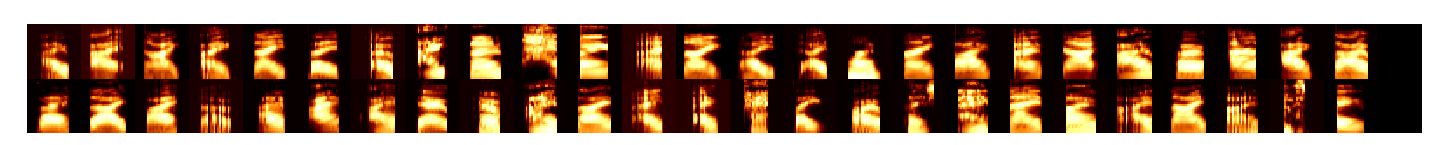

and 10892


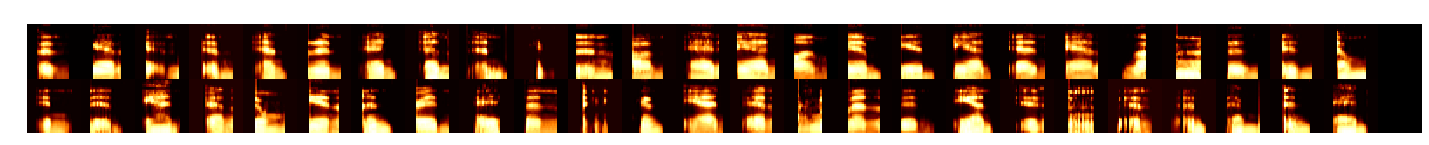

the 8300


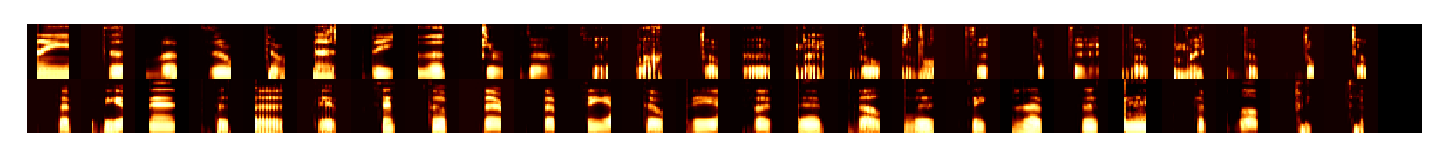

to 6383


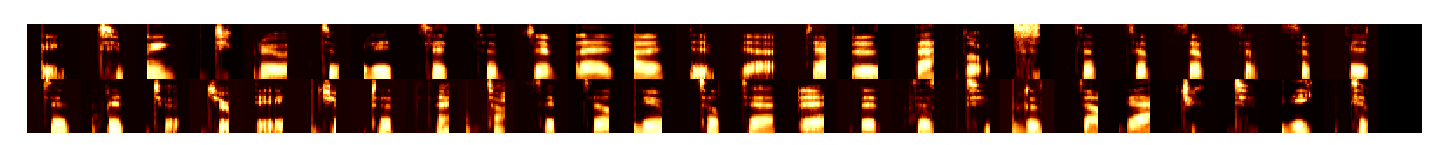

a 6114


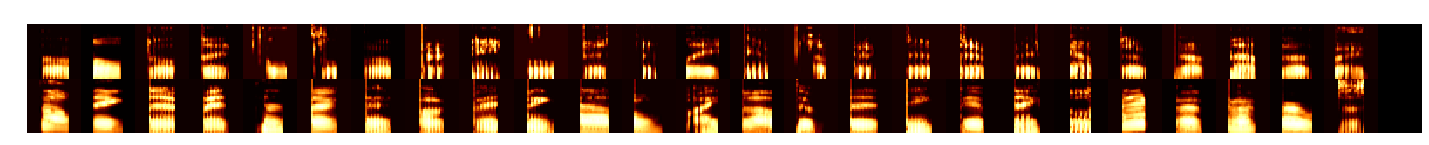

that 5802


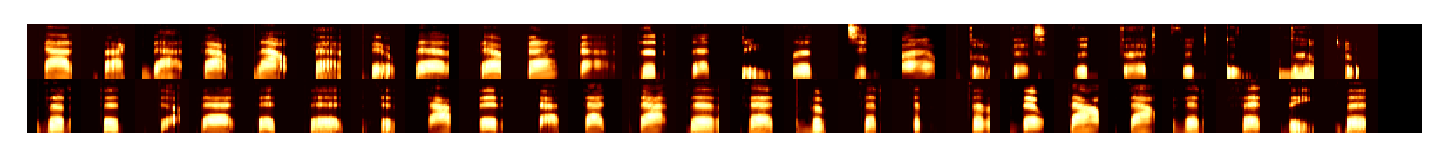

it 4565


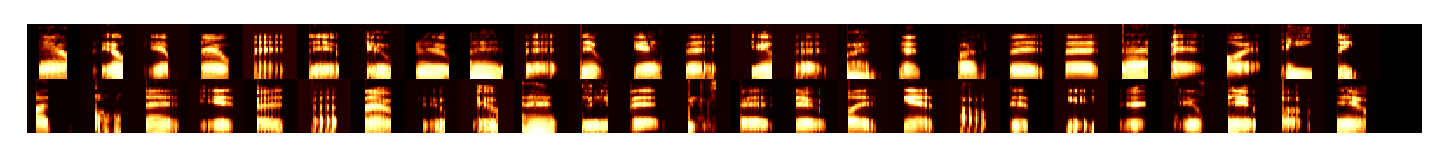

of 4329


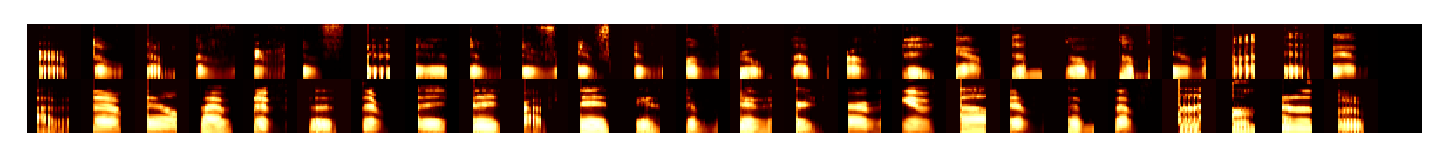

you 4301


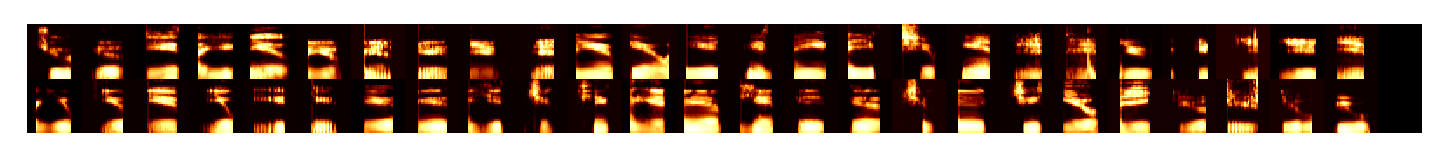

like 4055


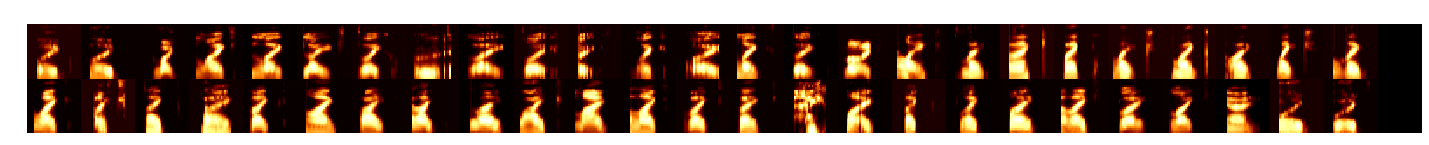

uh 3576


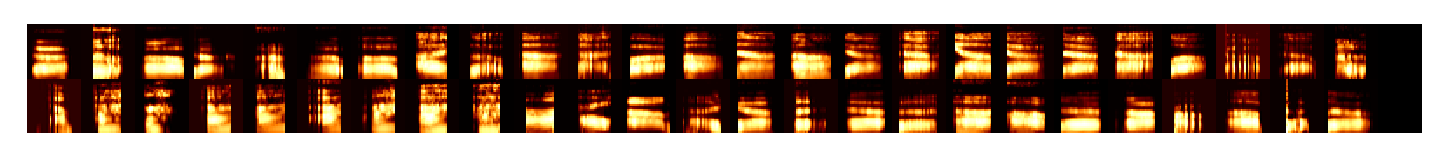

yknow 3567


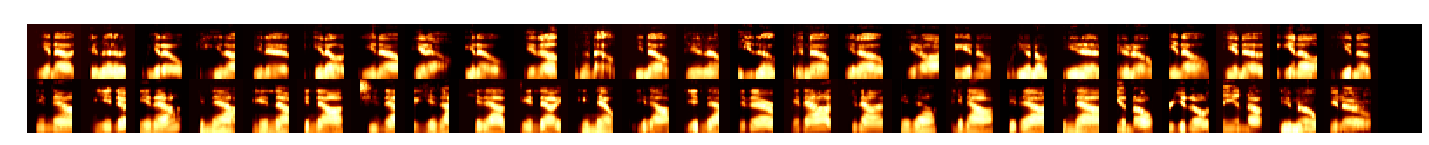

in 3566


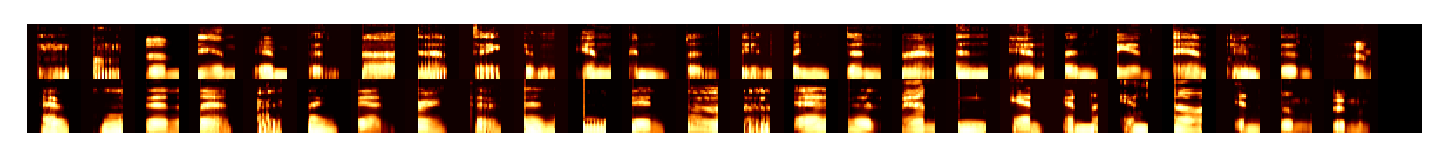

they 3502


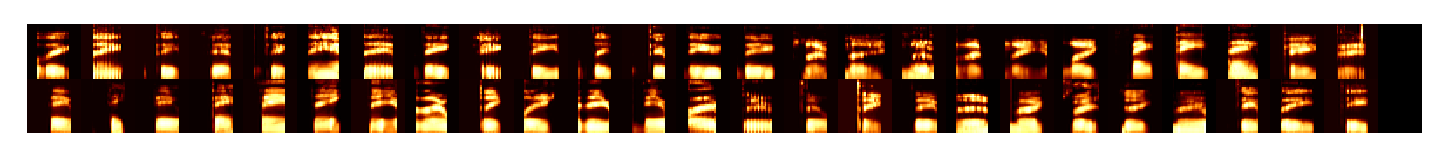

was 3055


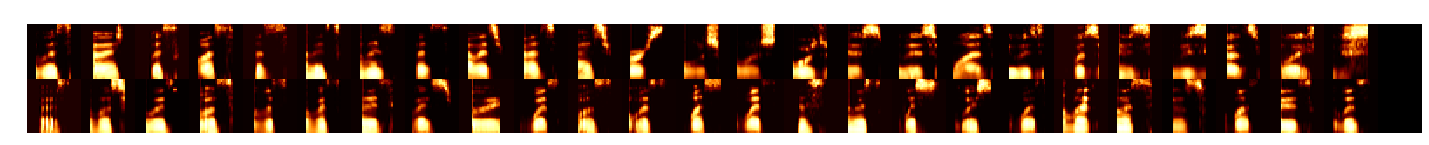

In [14]:
for word in tqdm(freq_words):
    subset_df = syllable_df[
        syllable_df.labels == word
    ]
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in specs]
    print(word, len(specs))
    draw_spec_set(specs, zoom=1, maxrows=2, colsize=25)

In [15]:
subset_df = syllable_df[
    syllable_df.labels.isin(freq_words.columns)
]

In [16]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(84049, 992)

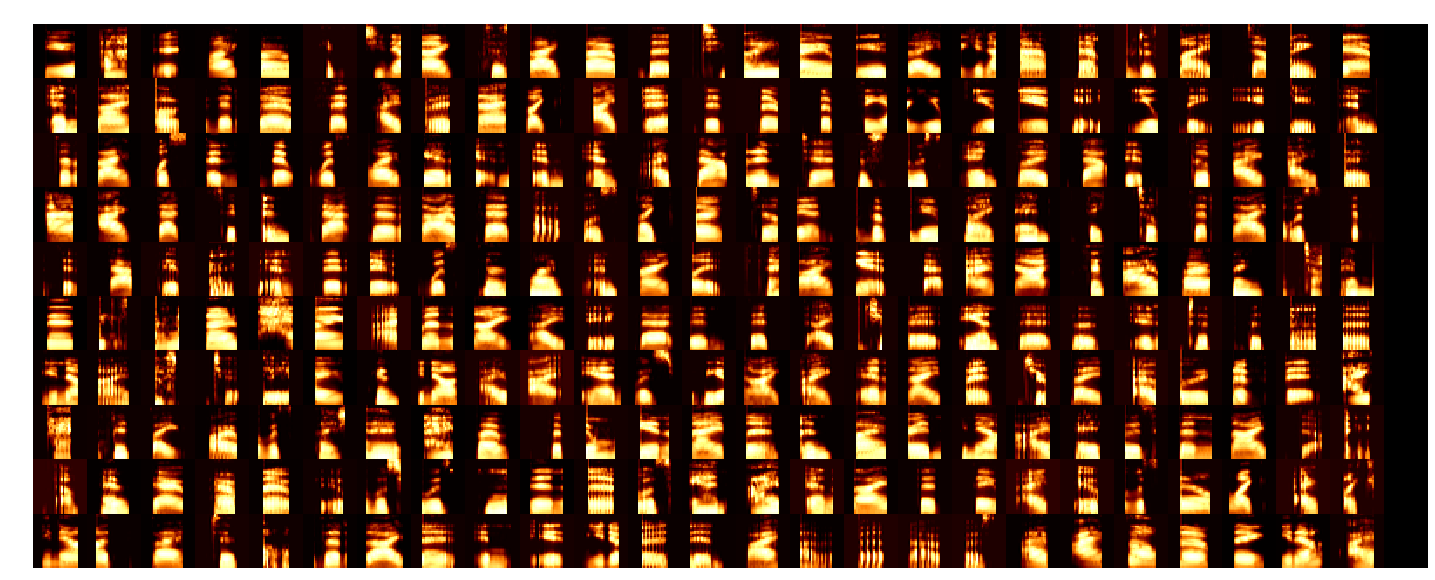

In [17]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [18]:
subset_df[:3]

,start_time,end_time,labels,utterance_number,PoS,position_in_utterance,indv,indvi,age,sex,key,audio,rate,spectrogram
1,5.698899,5.903525,yknow,0,PRP_VBP,2,s07,0,o,f,s0702b,"[0.0020050267415568897, -0.00886577761757358, ...",16000,"[[4, 4, 4, 4, 4, 86, 134, 142, 150, 150, 125, ..."
2,5.903525,6.099023,it,0,PRP,3,s07,0,o,f,s0702b,"[-0.4616742369795508, -0.22130549839909638, -0...",16000,"[[5, 5, 5, 5, 5, 127, 134, 133, 133, 135, 140,..."
4,6.526125,6.640816,i,0,PRP,6,s07,0,o,f,s0702b,"[0.045568528736657135, 0.048400479339309146, 0...",16000,"[[2, 2, 2, 2, 2, 2, 69, 80, 97, 113, 109, 107,..."


#### cluster and plot

In [19]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [21]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [22]:
cuml_umap = cumlUMAP()
embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [20]:
##fit = umap.UMAP()

In [23]:
np.shape(specs_flattened)

(84049, 992)

In [24]:
#z  = list(fit.fit_transform(specs_flattened))

In [25]:
z = np.vstack(embedding)

### variation across populations

(-5, 5)

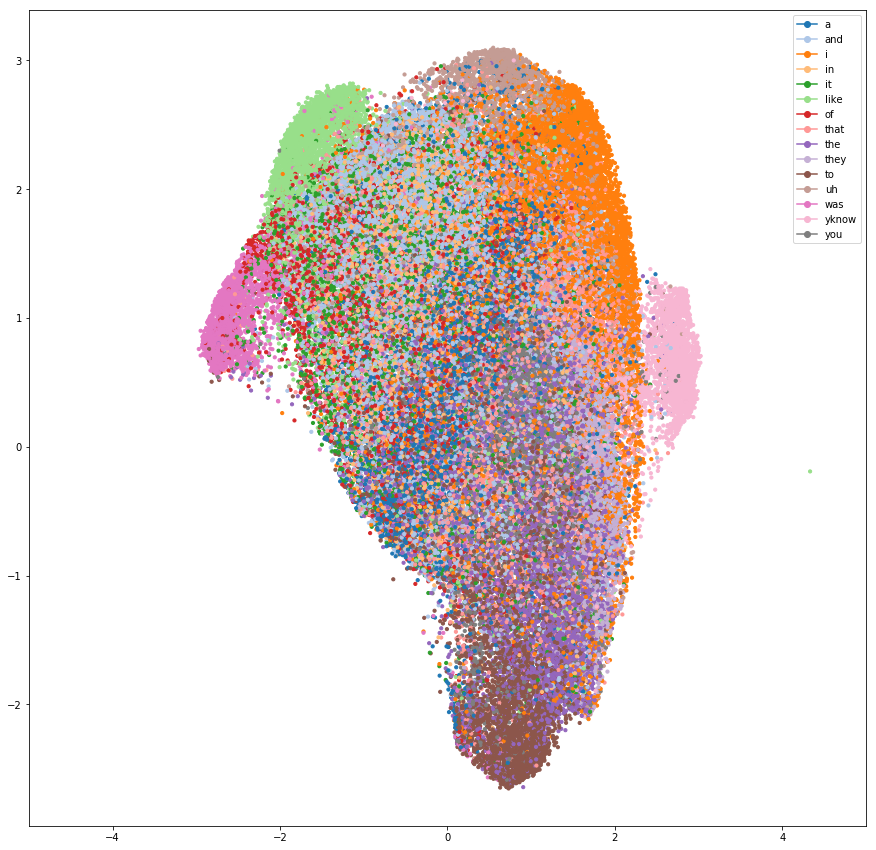

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = subset_df.labels.values, s=10, ax = ax)
ax.set_xlim([-5,5])

### draw transitions by population

In [29]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [31]:
nex = -1

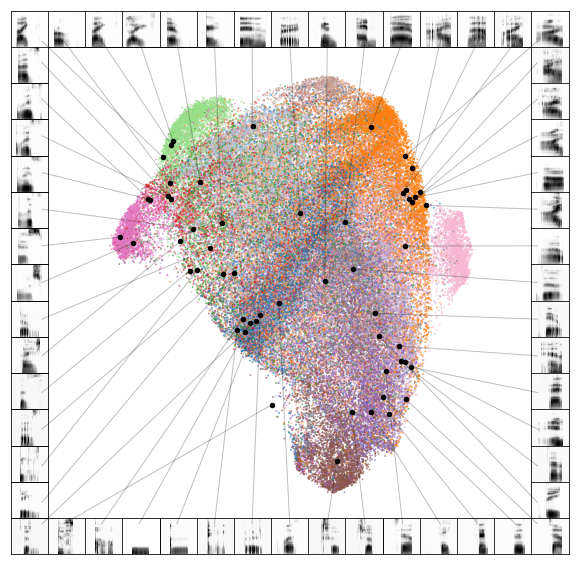

In [35]:
scatter_spec(
    z[:nex],
    specs[:nex],
    column_size=15,
    x_range = [-4,4],
    y_range = [-3,3.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': subset_df.labels.values[:nex],
        'alpha':0.5,
        's': 1,
        'show_legend': False,
        'color_palette': 'tab20'
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000
);
save_fig(FIGURE_DIR / 'words', dpi=300, save_jpg=True)